In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import math

In [2]:
dataset_path = Path().resolve().parent/'dataset/HomeC.csv'
df = pd.read_csv(dataset_path)
dataset_path

C:\Users\ngxin\anaconda3\envs\time-series-labs\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


WindowsPath('C:/Users/ngxin/projects/Capstone-Project-Time-Series-Forecasting/dataset/HomeC.csv')

In [3]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [4]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'Furnace', 'Kitchen'],
      dtype='object')

In [5]:
# Since the dataset has both energy and weather data, it is better we seperate them to do the resample method on them separately
# In this notebook, we are using use energy data only, so we are not doing any operation on the weather data
energy_data = df[['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen']]
energy_data

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,0.000967,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,0.000933,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,0.001000,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,0.000950,1.116033,0.000650


In [6]:
# aggregate the data in minutes into data in days 
data_per_hour = energy_data.resample("H").mean()
data_per_day = data_per_hour.resample("D").sum()

<AxesSubplot:>

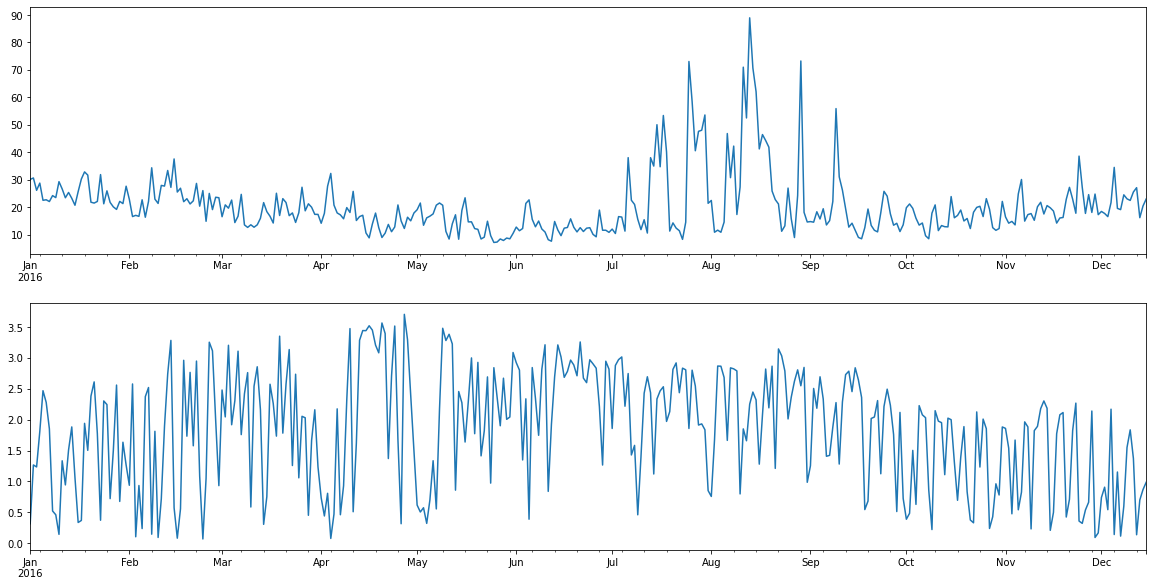

In [7]:
fig, axes = plt.subplots(nrows=2, ncols =1)
data_per_day["use"].plot(ax=axes[0],figsize = (20,10))
data_per_day["gen"].plot(ax=axes[1],figsize = (20,10))

# Simple Moving Average

In [8]:
# use pandas in-built rolling function to calculate simple moving average 
# we have calculate the simple average of 2 days 
# but notice that the result (simple average of 2 days) should be put in same row as 3rd day,
# which means the average of first two day is the forecast for 3rd day, 
# so we need to move the data later by one day
# later we will repeat the technique for all other number of days to be averaged
data_per_day["sma_2"] = data_per_day["use"].rolling(2).mean()
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen,sma_2
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536,NaN
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237,30.425033
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454,28.433940
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346,27.503084
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002,25.690492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857,24.055170
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664,26.370847
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495,21.695859
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405,18.363936


In [9]:
# use shift function in pandas library to shift the data by one day
data_per_day["sma_2"] = data_per_day["sma_2"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen,sma_2
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536,NaN
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237,NaN
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454,30.425033
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346,28.433940
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002,27.503084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857,22.803531
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664,24.055170
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495,26.370847
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405,21.695859


In [10]:
data_per_day["sma_3"] = data_per_day["use"].rolling(3).mean()
data_per_day["sma_3"] = data_per_day["sma_3"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen,sma_2,sma_3
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536,NaN,NaN
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237,NaN,NaN
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454,30.425033,NaN
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346,28.433940,29.012413
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002,27.503084,28.562292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857,22.803531,23.386135
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664,24.055170,23.732682
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495,26.370847,25.087017
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405,21.695859,22.994234


In [11]:
data_per_day["sma_7"] = data_per_day["use"].rolling(7).mean()
data_per_day["sma_7"] = data_per_day["sma_7"].shift(1)

In [12]:
data_per_day["sma_14"] = data_per_day["use"].rolling(14).mean()
data_per_day["sma_14"] = data_per_day["sma_14"].shift(1)

In [13]:
data_per_day["sma_30"] = data_per_day["use"].rolling(30).mean()
data_per_day["sma_30"] = data_per_day["sma_30"].shift(1)

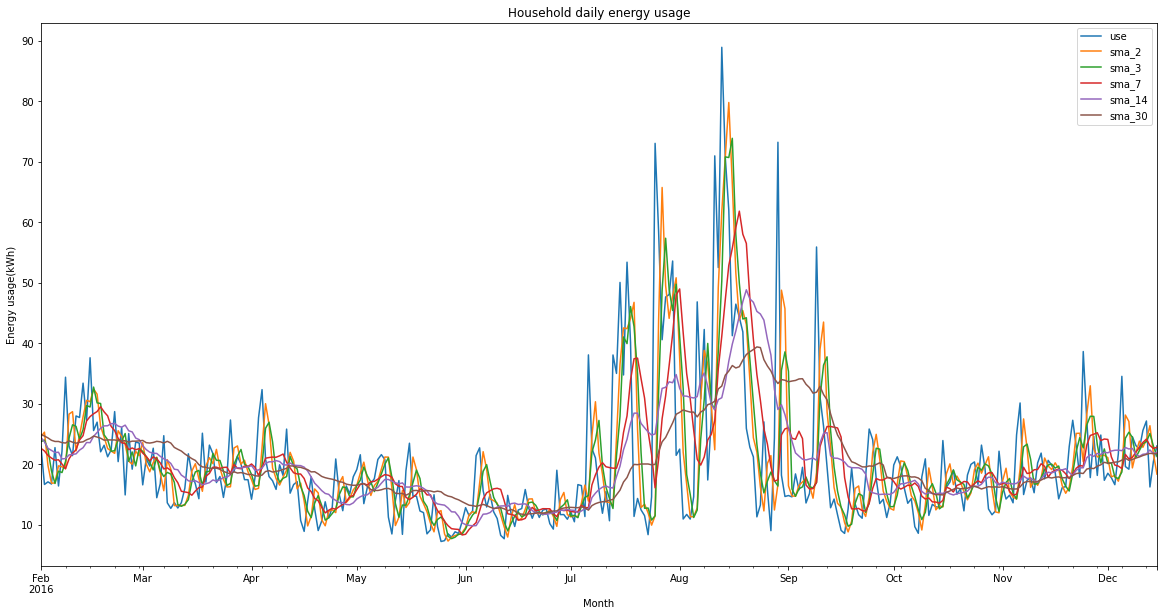

In [14]:
data_per_day.iloc[31:][["use","sma_2","sma_3","sma_7","sma_14","sma_30"]].plot(figsize=(20,10))
plt.title("Household daily energy usage")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Energy usage(kWh)")
plt.show()

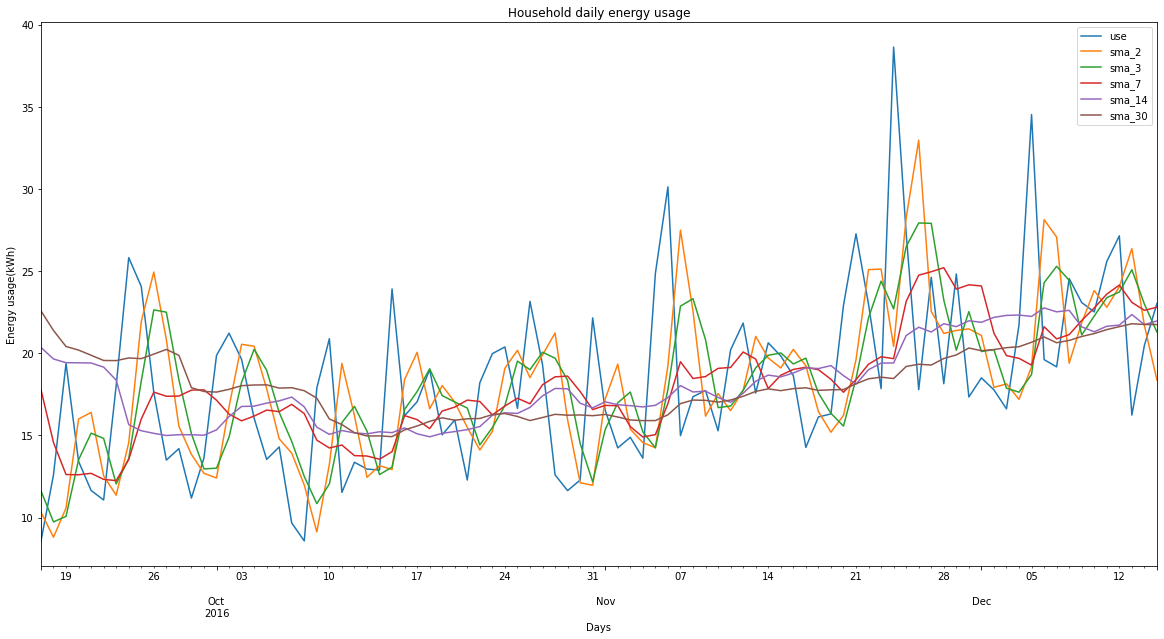

In [15]:
data_per_day.iloc[-90:][["use","sma_2","sma_3","sma_7", "sma_14", "sma_30"]].plot(figsize=(20,10))
plt.title("Household daily energy usage")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Energy usage(kWh)")
plt.show()

How to choose KPIs 
https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

In [16]:
rmse_sma_2 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_2"]]))
rmse_sma_3 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_3"]]))
rmse_sma_7 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_7"]]))
rmse_sma_14 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_14"]]))
rmse_sma_30 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_30"]]))

In [20]:
print("The RMSE of moving average of 2 day is : " ,rmse_sma_2)
print("The RMSE of moving average of 3 days is : " ,rmse_sma_3)
print("The RMSE of moving average of 7 days is : " ,rmse_sma_7)
print("The RMSE of moving average of 14 days is : " ,rmse_sma_14)
print("The RMSE of moving average of 30 days is : " ,rmse_sma_30)

The RMSE of moving average of 2 day is :  5.835015581136663
The RMSE of moving average of 3 days is :  5.546558103271683
The RMSE of moving average of 7 days is :  5.218876913188858
The RMSE of moving average of 14 days is :  5.1607238638193085
The RMSE of moving average of 30 days is :  5.332434673675999


In [21]:
mape_sma_2 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_2"]])
mape_sma_3 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_3"]])
mape_sma_7 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_7"]])
mape_sma_14 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_14"]])
mape_sma_30 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["sma_30"]])

In [22]:
print("The MAPE of moving average of 2 day is : " ,mape_sma_2)
print("The MAPE of moving average of 3 days is : " ,mape_sma_3)
print("The MAPE of moving average of 7 days is : " ,mape_sma_7)
print("The MAPE of moving average of 14 days is : " ,mape_sma_14)
print("The MAPE of moving average of 30 days is : " ,mape_sma_30)

The MAPE of moving average of 2 day is :  0.24262730000028543
The MAPE of moving average of 3 days is :  0.2384611765222963
The MAPE of moving average of 7 days is :  0.21776348830544556
The MAPE of moving average of 14 days is :  0.23164909925771682
The MAPE of moving average of 30 days is :  0.23717114943455186
